In [4]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable

from skimage import filters

# from skimage.filters import threshold_otsu, gaussian, apply_hysteresis_threshold

from skimage.transform import radon, iradon

In [5]:
""" Artifact Label Loading """

# Dental artifact labels (DAL)
dal = pd.read_csv("/cluster/home/carrowsm/data/radcure_DA_labels.csv",
#                      index_col="patient_id", 
                     dtype={"patient_id":str, "has_artifact":np.int16, "a_slice":np.int16},
                     usecols=["patient_id", "has_artifact", "a_slice"]
                 ).set_index("patient_id")

In [6]:
""" Image Loading """

# Directory containing unresampled NPY images
npy_dir = "/cluster/projects/radiomics/Temp/RADCURE-npy/img"

# Take five patient IDs from each DA class
s_img_ids = dal[dal["has_artifact"] == 2].iloc[0 : 5, :]
w_img_ids = dal[dal["has_artifact"] == 1].iloc[0 : 5, :]
n_img_ids = dal[dal["has_artifact"] == 0].iloc[0 : 5, :]


# Load one of each image
Xs = np.load(os.path.join(npy_dir, s_img_ids.index[0] + "_img.npy"))
Xw = np.load(os.path.join(npy_dir, w_img_ids.index[0] + "_img.npy"))
Xn = np.load(os.path.join(npy_dir, n_img_ids.index[0] + "_img.npy"))

# Make arrays of only the slice containing DA
simg = Xs[s_img_ids.loc[s_img_ids.index[0], "a_slice"], : , :]
wimg = Xw[w_img_ids.loc[w_img_ids.index[0], "a_slice"], : , :]
nimg = Xn[n_img_ids.loc[n_img_ids.index[0], "a_slice"], : , :]

In [15]:
mpl.style.use("classic")


# Function to plot three images
def plt3imgs(X1, X2, X3, t1="", t2="", t3="") :
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[12, 8])
    
    cm = cmap=plt.get_cmap("viridis")
    fig.set_facecolor('white')
    plt.rc('font', family='serif', size=15)
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')   

    im1 = ax[0].imshow(X1, cmap=cm)
    im2 = ax[1].imshow(X2, cmap=cm)
    im3 = ax[2].imshow(X3, cmap=cm)
    
    ax[0].set_title(t1)
    ax[1].set_title(t2)
    ax[2].set_title(t3)
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')
    
    fig.tight_layout(pad=0.5)
    
    plt.show()
    

# Plot two side-by-side images
def plt2imgs(X1, X2, t1="", t2="") :
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=[8, 4])
    
    cm = cmap=plt.get_cmap("viridis")
    fig.set_facecolor('white')
    plt.rc('font', family='serif', size=15)
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    
    im1 = ax[0].imshow(X1, cmap=cm)
    im2 = ax[1].imshow(X2, cmap=cm, 
                      extent=(0, 180, 0, X2.shape[0]), aspect='auto')
    
    ax[0].set_title(t1)
    ax[1].set_title(t2)
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    fig.tight_layout(pad=0.5)
    
    plt.show()

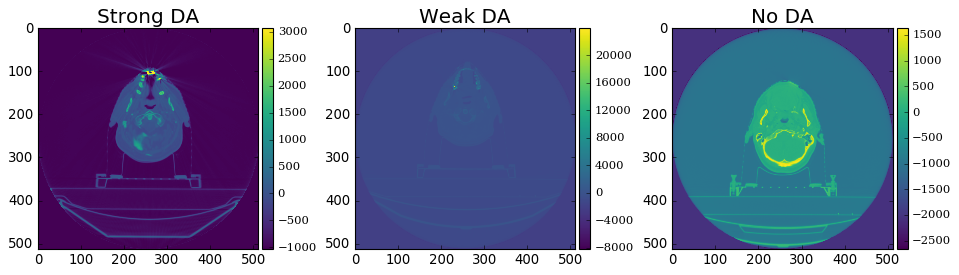

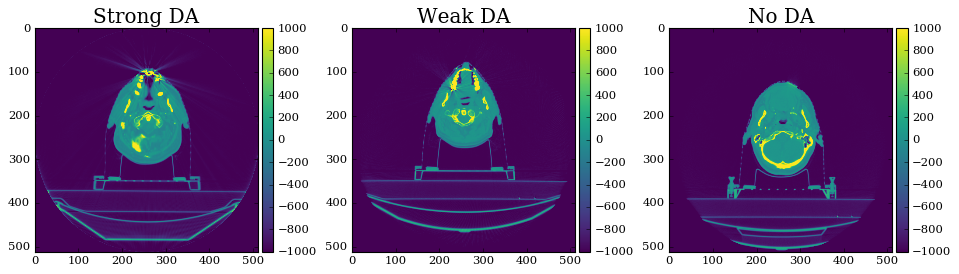

In [8]:
# Plot 3 raw images
plt3imgs(simg, wimg, nimg, t1="Strong DA", t2="Weak DA", t3="No DA")

# Plot 3 normalized images
plt3imgs(np.clip(simg, -1000, 1000), np.clip(wimg, -1000, 1000), np.clip(nimg, -1000, 1000), 
        t1="Strong DA", t2="Weak DA", t3="No DA")

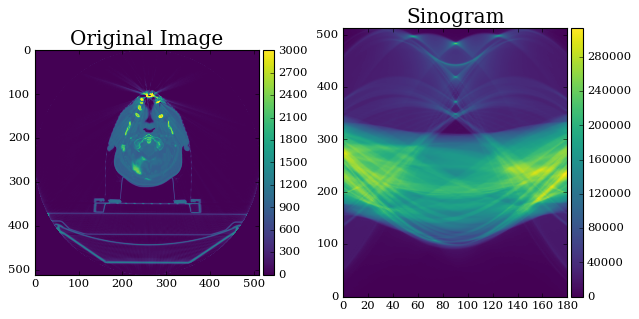

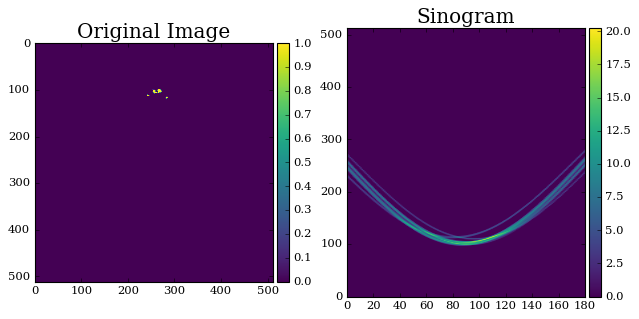

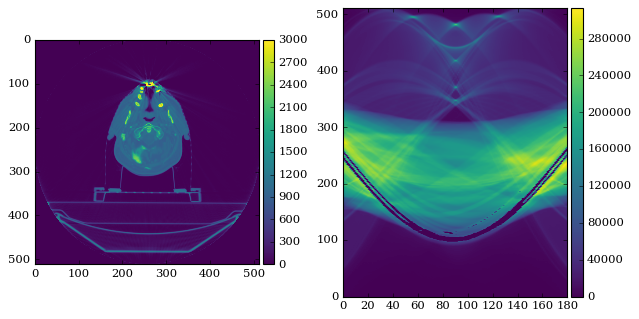

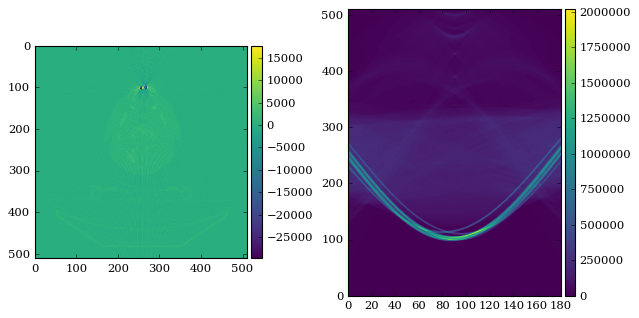

In [33]:
""" Transform to sinogram domain and threshold"""
X = np.clip(simg, -1000, 2000) + 1000

# Get original sinogram
theta = np.linspace(0., 180., 180, endpoint=False)
sinogram = radon(X, theta=theta, circle=True)

plt2imgs(X, sinogram, t1="Original Image", t2="Sinogram")



# Threshold image then make sinogram
# otsu = filters.threshold_otsu(sinogram)
Xt = np.array(simg > 2500, dtype=np.int32)
s = radon(Xt, theta=theta, circle=True)
plt2imgs(Xt, s, t1="Original Image", t2="Sinogram")


# Remove DA sinogram signal from original image
s_thresh = (sinogram * (s < 5))
plt2imgs(X, s_thresh)

img_reconstructed = iradon(s_thresh)
plt2imgs(img_reconstructed, s_thresh)